In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
from functools import lru_cache
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import rdkit
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

# Helper functions

In [2]:
@lru_cache(maxsize=100_000)
def get_fp_from_smi(smi):
    """
    Generates an RDKit fingerprint from a SMILES string.

    Parameters:
    smi (str): A SMILES string representing a chemical structure.

    Returns:
    RDKit.rdBase._vect: An RDKit fingerprint object if the SMILES string is valid.
    None: If the SMILES string is invalid or input type is not a string.
    """
    if type(smi) != float:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = Chem.RDKFingerprint(mol)
            return fp        
    return None

def convert_df_smis_to_fps(df, smi_column = 'SMILES'):
    """
    Converts a DataFrame of SMILES strings into a list of RDKit fingerprints.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame containing SMILES strings.
    smi_column (str): The column name in the DataFrame that contains the SMILES strings. Default is 'SMILES'.

    Returns:
    list: A list of RDKit fingerprint objects derived from the SMILES strings.
    """
    smiles = list(df[smi_column])
    fps = [get_fp_from_smi(smi) for smi in smiles]
    fps = [fp for fp in fps if fp is not None]
    return(fps)

def make_joined_list_of_fps_and_labels(list_of_lists, labels_in_order):
    """
    Joins multiple lists of fingerprints and their corresponding labels into single lists.

    Parameters:
    list_of_lists (list of lists): A list where each sublist contains fingerprints.
    labels_in_order (list): A list of labels corresponding to each sublist of fingerprints.

    Returns:
    tuple: Two lists:
        - A combined list of all fingerprints.
        - A corresponding list of labels, with each label repeated for the length of its sublist.
    """
    fp_list = []
    lab_list = []
    for lab, currlist in zip(labels_in_order, list_of_lists):
        fp_list.extend(currlist) # could be slow for long lists or many long lists
        lab_list.extend([lab] * len(currlist))
    return(fp_list, lab_list)

def tsne_from_pca_components(fp_list, fp_labels, fig_path, colors = None):
    """
    Generates a 2D t-SNE plot from PCA components of a list of fingerprints.

    Parameters:
    fp_list (list): A list of RDKit fingerprints or feature vectors.
    fp_labels (list): A list of labels corresponding to the fingerprints.
    fig_path (str): The file path to save the generated plot (without extension).
    colors (list, optional): A list of colors for the plot. If None, a default color palette is used.

    Returns:
    None: Saves the t-SNE plot as PNG and SVG files and displays it.
    """
    # use all PCs
    pca = PCA(n_components=np.min([len(fp_list), len(fp_list[0])]))
    crds = pca.fit_transform(fp_list)

    # use PCs as input to tSNE
    crds_embedded = TSNE(n_components=2).fit_transform(crds)

    tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
    tsne_df['label'] = fp_labels
              
    plt.figure(figsize=(8,5), dpi = 300)
    if colors == None:
        palette = sns.color_palette("hls", len(set(fp_labels)))
    else:
        ordered_labs = tsne_df.drop_duplicates('label')
        palette = dict(zip(list(ordered_labs['label']), colors))
    ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="label", palette = palette, alpha = 0.7, s = 7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(fig_path + '.png')
    plt.savefig(fig_path + '.svg')  
    plt.show()

# Plot 37K, abx, PK-1760 t-SNE

In [3]:
data_path = '../data/'

full37kpk = pd.read_csv(data_path + 'data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv')
print('num 37K + PK: ', len(full37kpk))

pkonly = pd.read_csv(data_path + 'data_prep_for_ml/data_prep_for_ml_pk_screen/FULL_11_15_2021.csv')
print('num PK only: ', len(pkonly))

full37konly = full37kpk[[smi not in list(pkonly['SMILES']) for smi in list(full37kpk['SMILES'])]]
print('num 37K only: ', len(full37konly))

abx = pd.read_csv(data_path + '04052022_CLEANED_v5_antibiotics_across_many_classes.csv')
print('num abx: ', len(abx))

num 37K + PK:  38680
num PK only:  1759
num 37K only:  36897
num abx:  566


/Users/jackie16201/opt/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


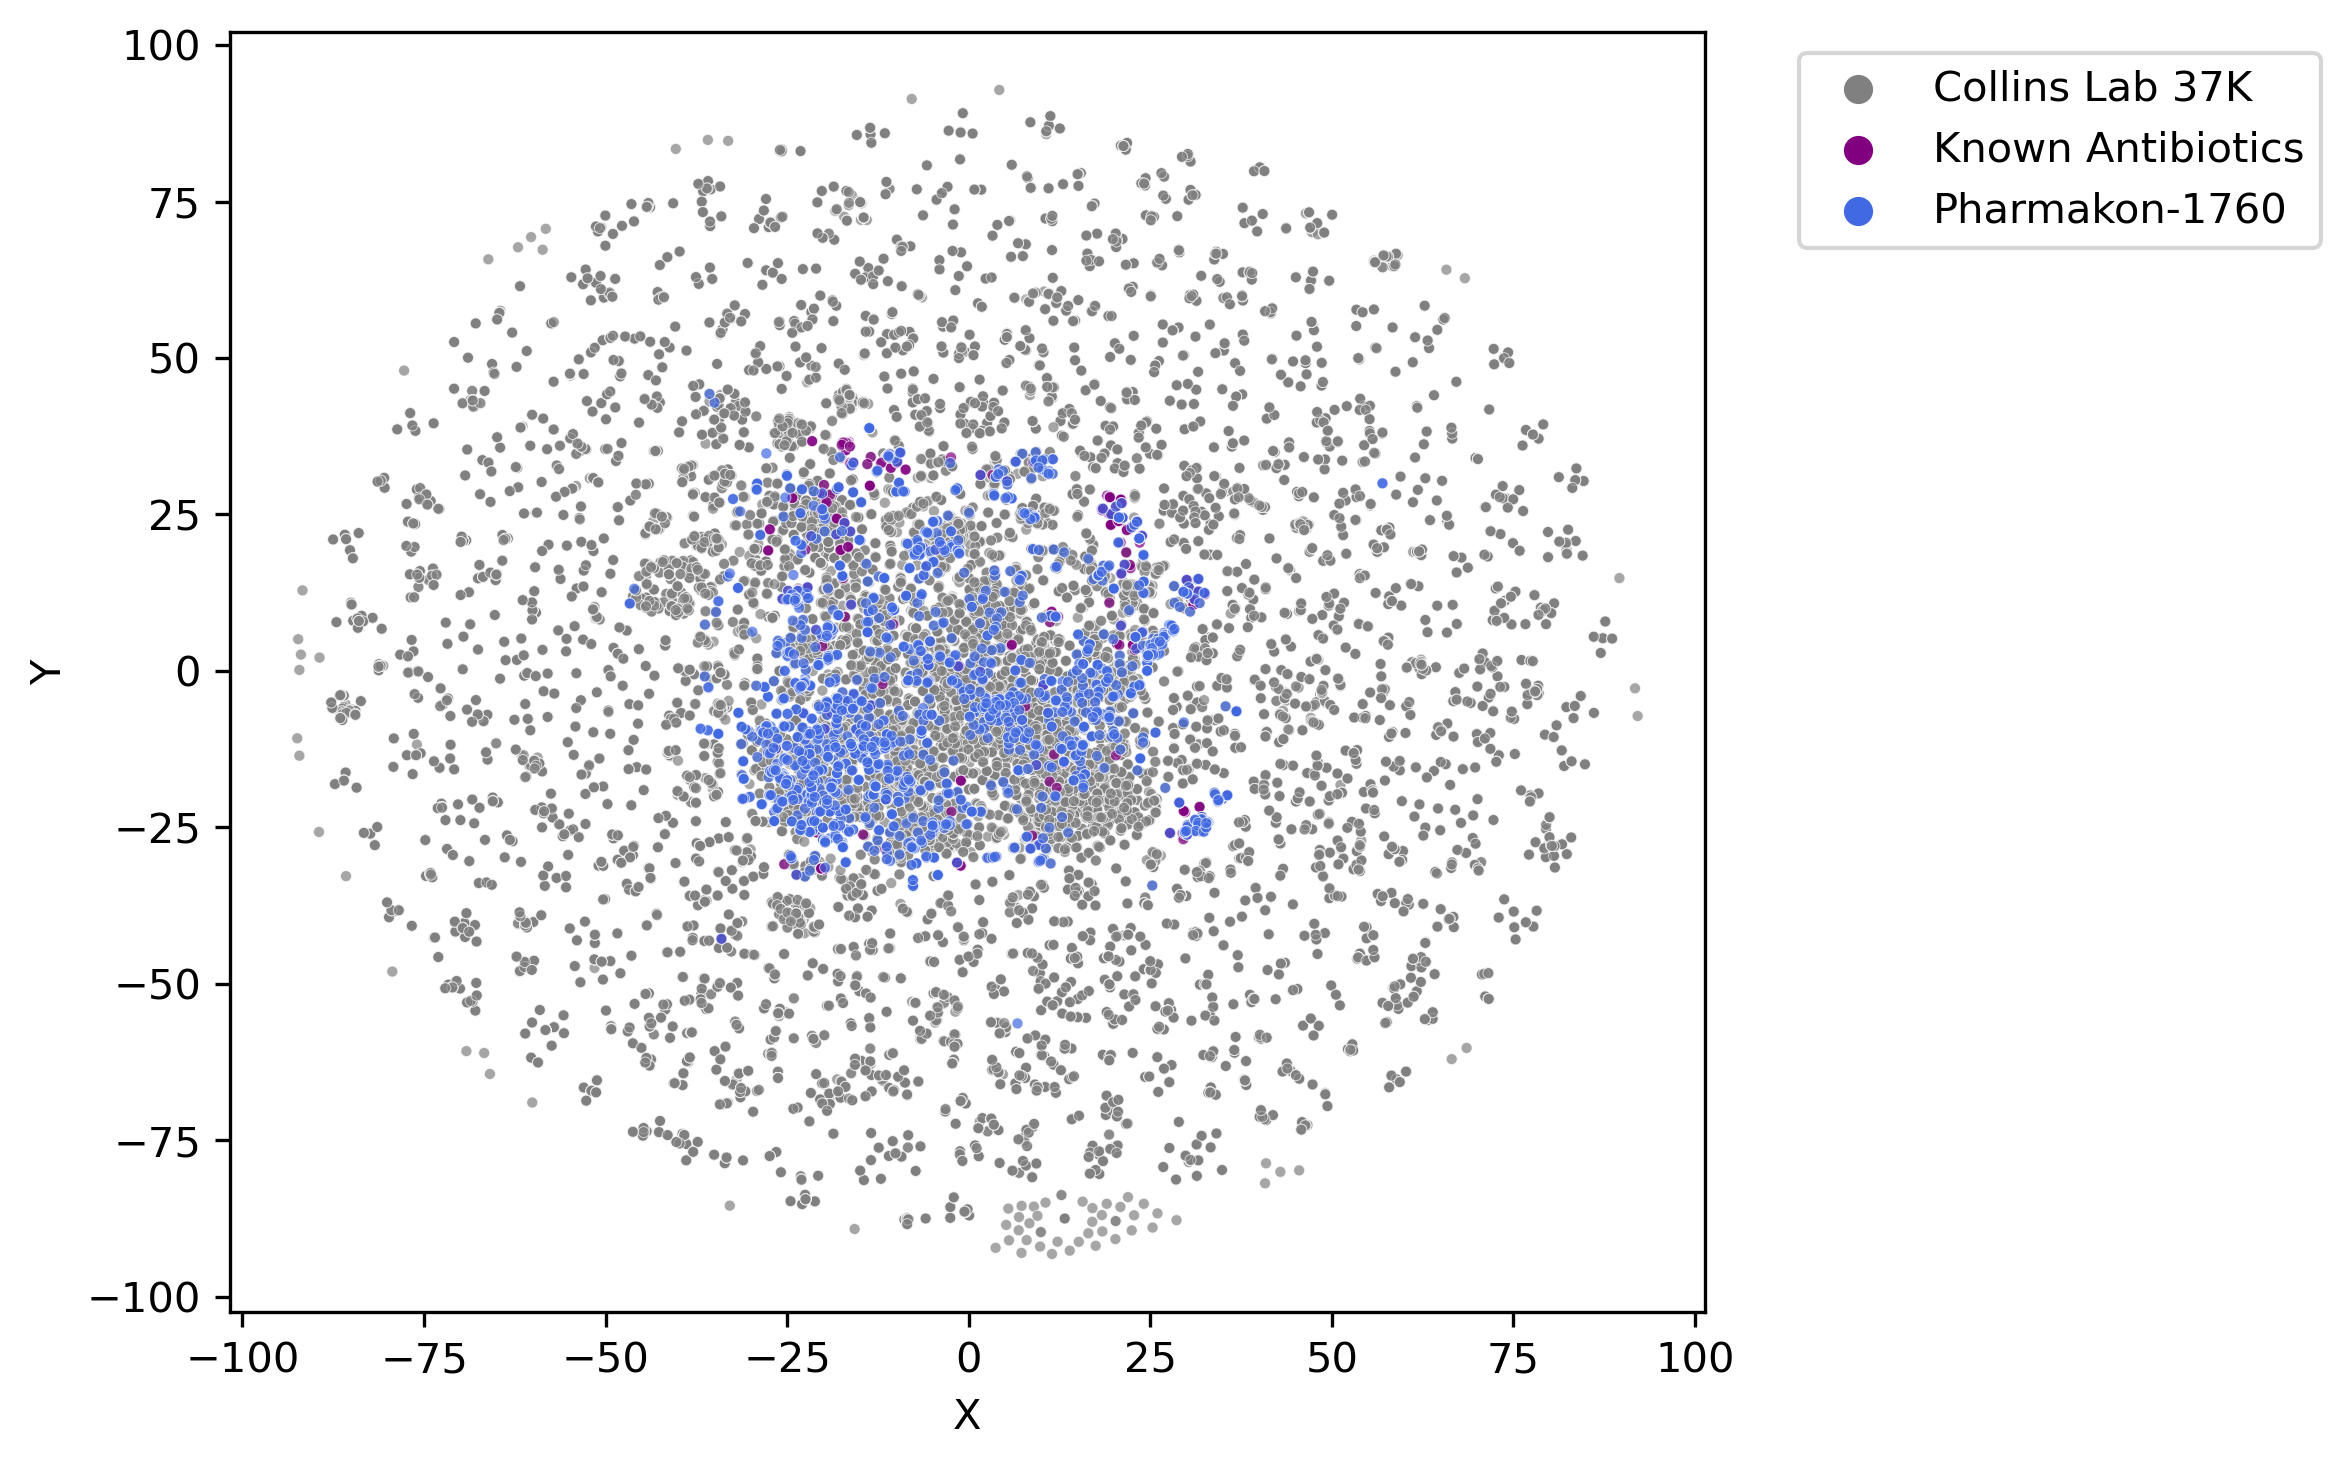

In [4]:
fp_37k = convert_df_smis_to_fps(full37konly, 'SMILES')
fp_abx = convert_df_smis_to_fps(abx, 'Smiles')
fp_pk = convert_df_smis_to_fps(pkonly, 'SMILES')

fp_list, fp_labels = make_joined_list_of_fps_and_labels([fp_37k, fp_abx, fp_pk], 
                                                       ['Collins Lab 37K', 'Known Antibiotics', 'Pharmakon-1760'])

tsne_from_pca_components(fp_list, fp_labels, '../figure_panels/tsne_37k_PK_abx', colors = ['grey', 'purple', 'royalblue'])

# Plot 37K+PK hits and non-hits, abx t-SNE

/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


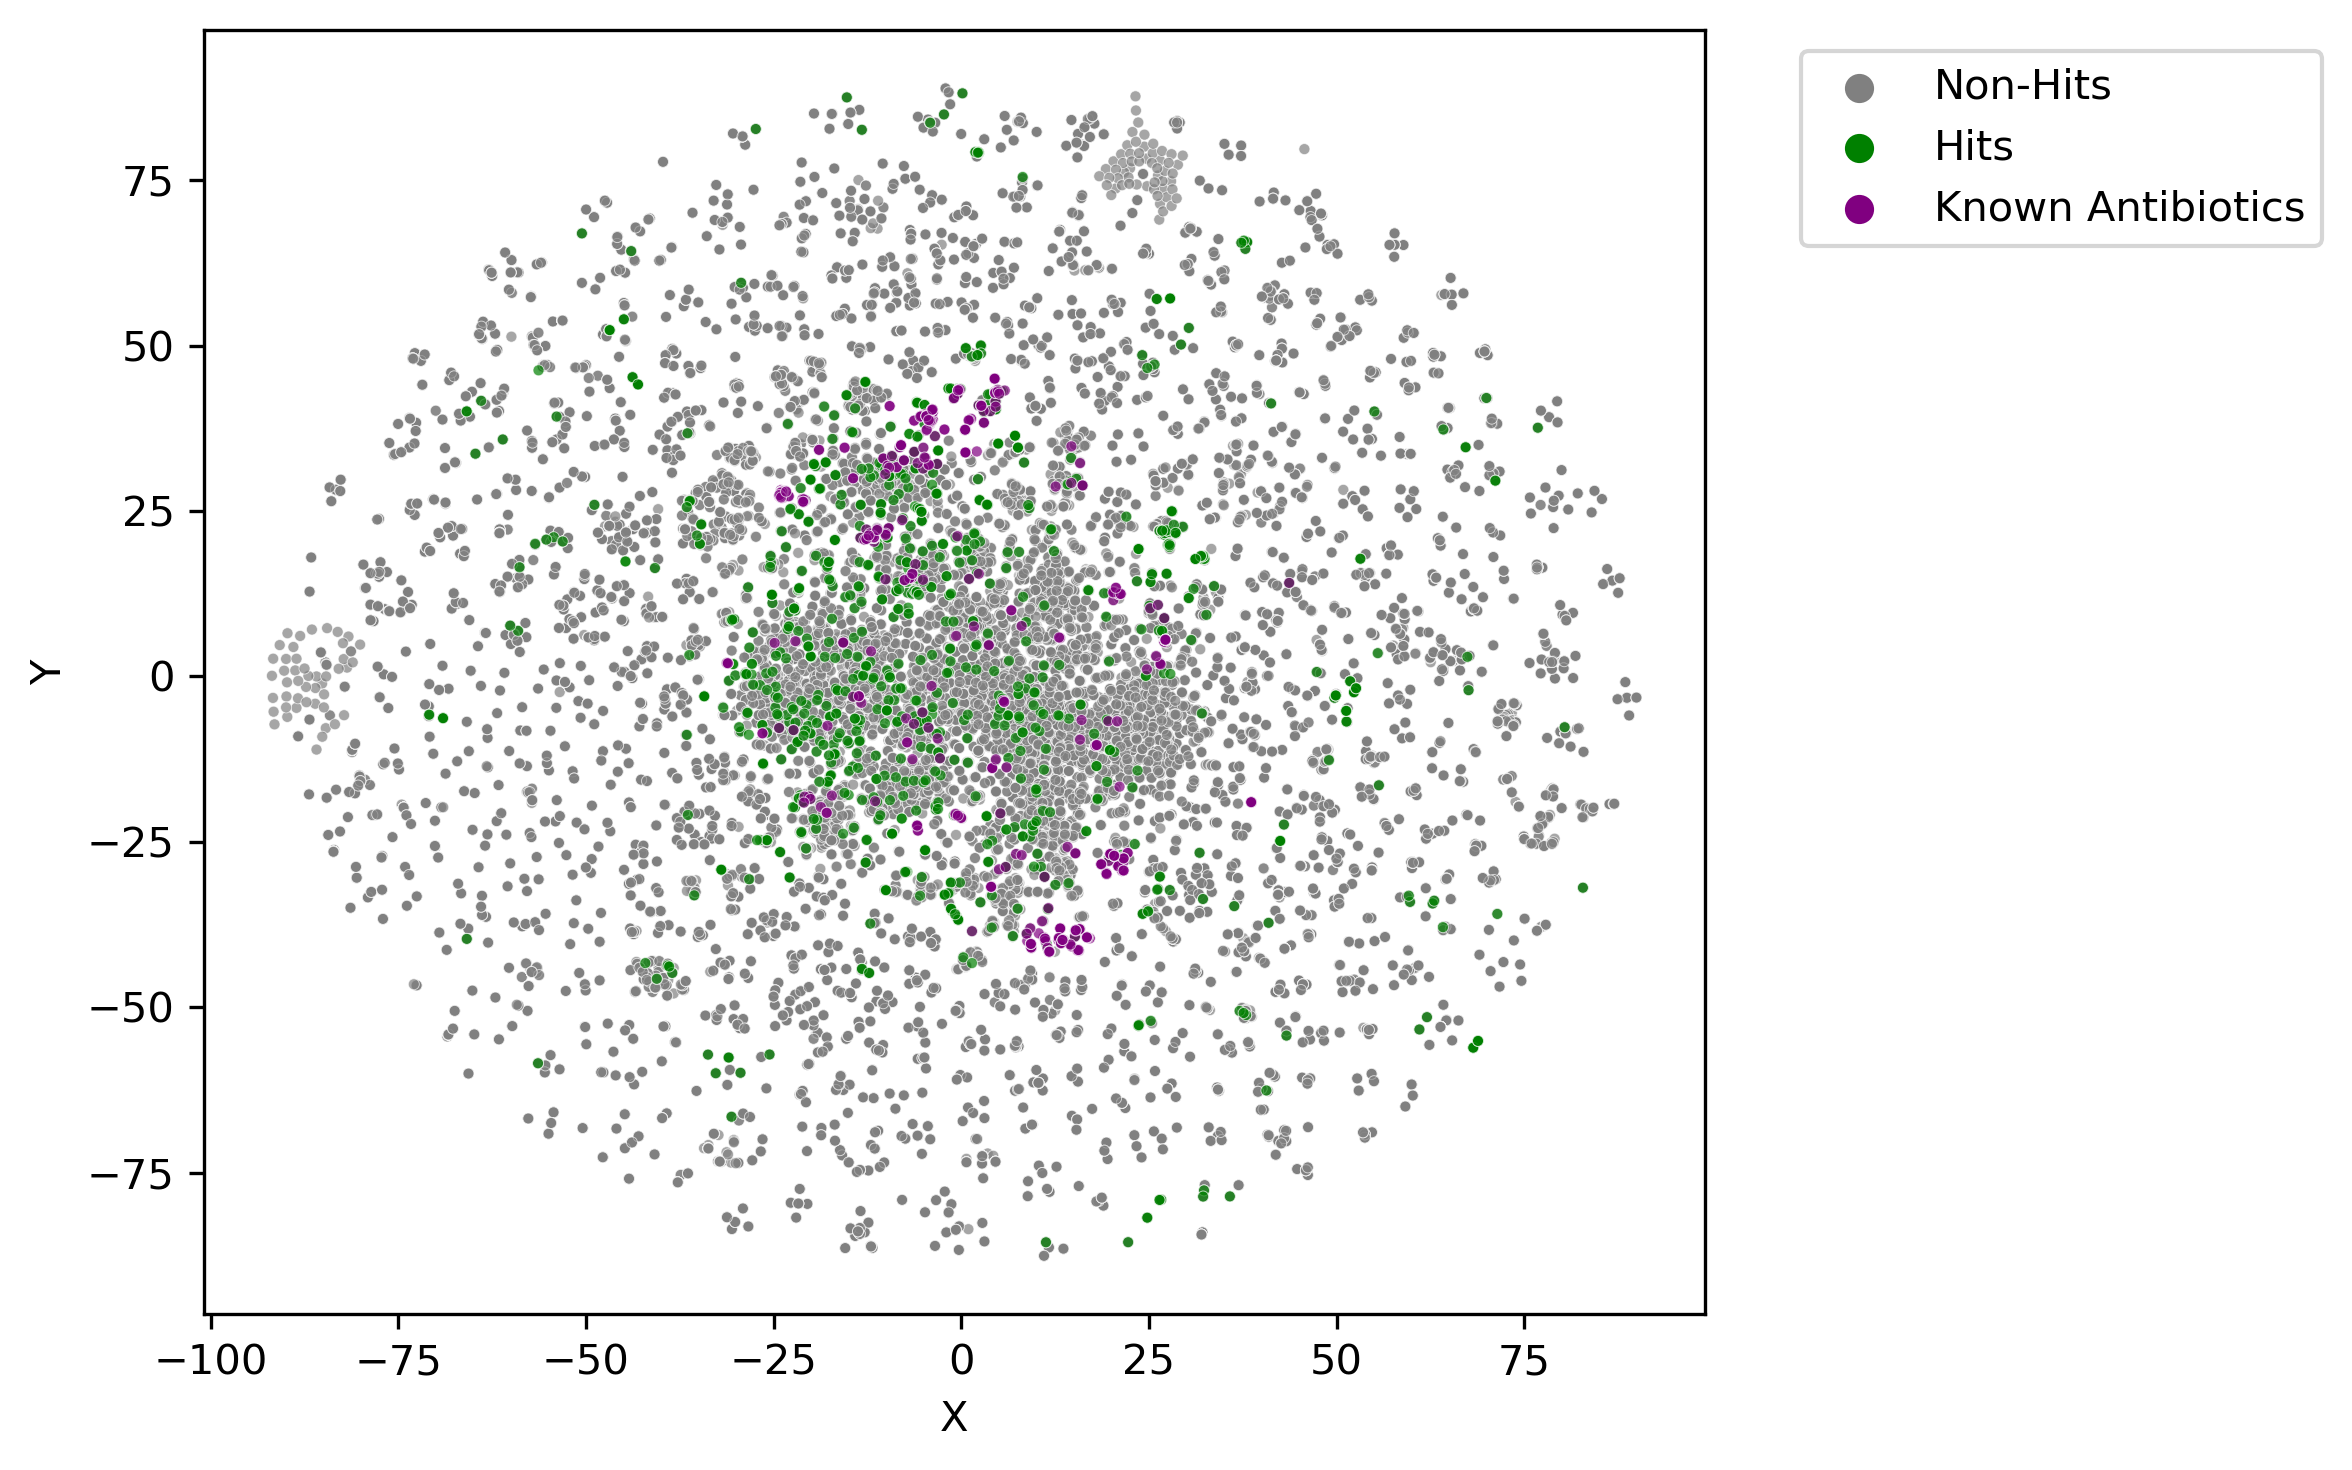

In [ ]:
full37kpkhits = full37kpk[full37kpk['hit'] == 1.0]
full37kpknonhits = full37kpk[full37kpk['hit'] == 0.0]

fp_37kpkhits = convert_df_smis_to_fps(full37kpkhits)
fp_37kpknonhits = convert_df_smis_to_fps(full37kpknonhits)

fp_list, fp_labels = make_joined_list_of_fps_and_labels([fp_37kpknonhits, fp_37kpkhits, fp_abx], 
                                                       ['Non-Hits', 'Hits', 'Known Antibiotics'])

#tsne_from_pca_components(fp_list, fp_labels, '../figure_panels/tsne_hits_nonhits_abx', colors = ['grey', 'green', 'purple'])

# Quantify diversity

In [5]:
# Get fingerprints for each dataset individually - 37K, abx, PK, and then combine 37K+PK
fp_37k = convert_df_smis_to_fps(full37konly, 'SMILES')
fp_abx = convert_df_smis_to_fps(abx, 'Smiles')
fp_pk = convert_df_smis_to_fps(pkonly, 'SMILES')
fp_37k_pk = fp_37k + fp_pk

# Get hits and nonhits from 37K + PK combined
full37kpkhits = full37kpk[full37kpk['hit'] == 1.0]
full37kpknonhits = full37kpk[full37kpk['hit'] == 0.0]
fp_37kpkhits = convert_df_smis_to_fps(full37kpkhits)
fp_37kpknonhits = convert_df_smis_to_fps(full37kpknonhits)

# Get hits and nonhits from PK alone
pkhits = pkonly[pkonly['hit'] == 1.0]
pknonhits = pkonly[pkonly['hit'] == 0.0]
fp_pkhits = convert_df_smis_to_fps(pkhits)
fp_pknonhits = convert_df_smis_to_fps(pknonhits)

# Get hits and nonhits from 37K alone
only37khits = full37konly[full37konly['hit'] == 1.0]
only37knonhits = full37konly[full37konly['hit'] == 0.0]
fp_only37khits = convert_df_smis_to_fps(only37khits)
fp_only37knonhits = convert_df_smis_to_fps(only37knonhits)

In [6]:
print(len(fp_37kpkhits), len(fp_37kpknonhits))
print(len(fp_pkhits), len(fp_pknonhits))
print(len(fp_only37khits), len(fp_only37knonhits))

1269 37411
327 1432
929 35968


In [7]:
@lru_cache(maxsize=100_000)
def get_murcko(smi):
    """
    Extracts the Bemis-Murcko scaffold from a SMILES string.

    Parameters:
    smi (str): A SMILES string representing a chemical structure.

    Returns:
    str: A SMILES string representing the Bemis-Murcko scaffold of the input molecule.
         Returns an empty string if the SMILES string is invalid or the molecule cannot be processed.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return ""

def get_unique_scaffolds(smiles_list):
    """
    Computes the number of unique scaffolds from a list of SMILES strings.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    int: Number of unique scaffolds.
    """
    scaffolds = set()
    for smi in smiles_list:
        scaffolds.add(get_murcko(smi))
    return len(scaffolds)

# full datasets
print('PK number of scaffolds:', get_unique_scaffolds(pkonly['SMILES']))
print('full37konly number of scaffolds:', get_unique_scaffolds(full37konly['SMILES']))
print('PK+37K number of scaffolds: ', get_unique_scaffolds(full37kpk['SMILES']))
print('abx number of scaffolds:', get_unique_scaffolds(abx['Smiles']))

# hits vs non-hits
print('PK+37K hits number of scaffolds:', get_unique_scaffolds(full37kpkhits['SMILES']))
print('PK+37K non-hits number of scaffolds:', get_unique_scaffolds(full37kpknonhits['SMILES']))
print('37K alone hits number of scaffolds:', get_unique_scaffolds(only37khits['SMILES']))
print('37K alone non-hits number of scaffolds:', get_unique_scaffolds(only37knonhits['SMILES']))
print('PK alone hits number of scaffolds:', get_unique_scaffolds(pkhits['SMILES']))
print('PK alone non-hits number of scaffolds:', get_unique_scaffolds(pknonhits['SMILES']))

PK number of scaffolds: 877
full37konly number of scaffolds: 8598
PK+37K number of scaffolds:  9305
abx number of scaffolds: 288
PK+37K hits number of scaffolds: 887
PK+37K non-hits number of scaffolds: 8718
37K alone hits number of scaffolds: 687
37K alone non-hits number of scaffolds: 8147
PK alone hits number of scaffolds: 217
PK alone non-hits number of scaffolds: 721


In [8]:
def average_tanimoto_similarity(fps):
    """
    Computes the average Tanimoto similarity for all pairwise comparisons of a list of fingerprints.

    Parameters:
    fps (list): List of fingerprints.

    Returns:
    float: Average Tanimoto similarity across all pairs.
    """
    total_similarity = 0.0
    num_pairs = 0

    for fp1, fp2 in combinations(fps, 2):
        total_similarity += DataStructs.TanimotoSimilarity(fp1, fp2)
        num_pairs += 1
    
    return total_similarity / num_pairs if num_pairs > 0 else 0.0

# full datasets
print('PK mean tan sim: ', average_tanimoto_similarity(fp_pk))
print('full37konly mean tan sim', average_tanimoto_similarity(fp_37k))
print('PK+37K mean tan sim: ', average_tanimoto_similarity(fp_37k_pk))
print('abx mean tan sim:', average_tanimoto_similarity(fp_abx))

# hits vs non-hits
print('PK+37K hits mean tan sim:', average_tanimoto_similarity(fp_37kpkhits))
print('PK+37K non-hits mean tan sim:', average_tanimoto_similarity(fp_37kpknonhits))
print('37K alone hits mean tan sim:', average_tanimoto_similarity(fp_only37khits))
print('37K alone non-hits mean tan sim:', average_tanimoto_similarity(fp_only37knonhits))
print('PK alone hits mean tan sim:', average_tanimoto_similarity(fp_pkhits))
print('PK alone non-hits mean tan sim:', average_tanimoto_similarity(fp_pknonhits))

PK mean tan sim:  0.17850875380161021
full37konly mean tan sim 0.4484375689412942
PK+37K mean tan sim:  0.42992530149097374
abx mean tan sim: 0.37469254457202433
PK+37K hits mean tan sim: 0.3100122334014664
PK+37K non-hits mean tan sim: 0.43539904396547785
37K alone hits mean tan sim: 0.34399644942545854
37K alone non-hits mean tan sim: 0.45242165383027966
PK alone hits mean tan sim: 0.23827067253324605
PK alone non-hits mean tan sim: 0.16888386603698538


In [9]:
def sum_bottleneck(fps):
    """
    Computes the sum of the minimum Tanimoto distances from each molecule to its closest neighbor
    in a list of SMILES strings.

    Normalized by the number of molecules in the list.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    float: Sum of the minimum Tanimoto distances to the closest neighbor for each molecule.
    """    
    # Initialize list to store minimum distances for each molecule
    min_distances = []
    
    # For each fingerprint, compute the minimum "distance" (1 - Tanimoto similarity) to another molecule
    for i, fp1 in enumerate(fps):
        min_distance = float('inf')  # Start with a large number for minimum comparison
        
        # Compare fp1 with every other fingerprint
        for j, fp2 in enumerate(fps):
            if i != j:  # Avoid self-comparison
                similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
                distance = 1 - similarity  # Convert similarity to distance
                min_distance = min(min_distance, distance)  # Update minimum distance if smaller
                
        # Append the minimum distance to the list
        min_distances.append(min_distance)
    
    # Return the sum of all minimum distances
    return sum(min_distances) / len(min_distances)

# full datasets
print('PK sum bottleneck:', sum_bottleneck(fp_pk))
print('full37konly sum bottleneck:', sum_bottleneck(fp_37k))
print('PK+37K sum bottleneck:', sum_bottleneck(fp_37k_pk))
print('abx sum bottleneck:', sum_bottleneck(fp_abx))

# hits vs non-hits
print('PK+37K hits sum bottleneck:', sum_bottleneck(fp_37kpkhits))
print('PK+37K non-hits sum bottleneck:', sum_bottleneck(fp_37kpknonhits))
print('37K alone hits sum bottleneck:', sum_bottleneck(fp_only37khits))
print('37K alone non-hits sum bottleneck:', sum_bottleneck(fp_only37knonhits))
print('PK alone hits sum bottleneck:', sum_bottleneck(fp_pkhits))
print('PK alone non-hits sum bottleneck:', sum_bottleneck(fp_pknonhits))

PK sum bottleneck: 0.30786607784137254
full37konly sum bottleneck: 0.060402031800654246
PK+37K sum bottleneck: 0.06424908414993417
abx sum bottleneck: 0.13216816207506826
PK+37K hits sum bottleneck: 0.22243860389868636
PK+37K non-hits sum bottleneck: 0.0619849004078915
37K alone hits sum bottleneck: 0.2215017637636981
37K alone non-hits sum bottleneck: 0.058500830911090956
PK alone hits sum bottleneck: 0.36685104090833304
PK alone non-hits sum bottleneck: 0.3242852066679661
